In [363]:
!pip install talib-binary
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [364]:
# przetwarzanie  
import numpy as np
import pandas as pd
import os 
import tarfile
import urllib 
import yfinance as yf


# wizualizacja   
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from pandas.plotting import scatter_matrix

# model 
from sklearn.model_selection import train_test_split 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import joblib

# współczynniki oceny 

from sklearn.metrics import mean_absolute_error

#współczynniki analizy technicznej 
import talib as tb
from talib import abstract

# **Prezentacja, opis i analiza danych**

Dane opisują główne ceny surowców z ostatnich 22 lat (2000-2022).

* Symbol: główne towary będące obrotem handlu tj. Ropa brent, Złoto, Gaz ziemny, Nikiel, Pallad, Pszenica amerykańska
* Date: data dla któej wskazane zostały parametry
* Open: cena otwarcia
* High: najwyższa cena w danym dniu 
*Low: najniższa cena w danym dniu
*Close: cena zamknięcia
*Volume: ilość transakcji zawartych, opartych na cenach zamknięcia

In [365]:
commodity = pd.read_csv('/content/commodity 2000-2022.csv', sep=',', decimal='.')
commodity

,Symbol,Date,Open,High,Low,Close,Volume
0,Gold,2000-01-04,281.00,281.00,281.00,282.70,4
1,Gold,2000-01-05,283.20,283.20,283.20,281.10,16
2,Gold,2000-01-06,281.40,281.40,281.40,281.40,0
3,Gold,2000-01-07,281.90,281.90,281.90,281.90,0
4,Gold,2000-01-10,281.70,281.70,281.70,281.70,0
...,...,...,...,...,...,...,...
29930,US Wheat,2022-04-04,989.50,1014.50,984.75,1010.25,0
29931,US Wheat,2022-04-05,1020.50,1074.00,1020.00,1045.25,0
29932,US Wheat,2022-04-06,1049.40,1056.40,1024.25,1041.12,0
29933,US Wheat,2022-04-07,1040.25,1044.50,1017.75,1020.00,0


Celem projektu jest predykcja różnicy zmiany ceny zamknięcia w następnym dniu roboczym. Pozostałe dane dla innych towarów zostaną usunięte. 

In [366]:
groupby = commodity.groupby('Symbol')
groupby.groups #stworzył sie słownik, 6 grup

{'Brent Oil': [12701, 12702, 12703, 12704, 12705, 12706, 12707, 12708, 12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12717, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12728, 12729, 12730, 12731, 12732, 12733, 12734, 12735, 12736, 12737, 12738, 12739, 12740, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12750, 12751, 12752, 12753, 12754, 12755, 12756, 12757, 12758, 12759, 12760, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12768, 12769, 12770, 12771, 12772, 12773, 12774, 12775, 12776, 12777, 12778, 12779, 12780, 12781, 12782, 12783, 12784, 12785, 12786, 12787, 12788, 12789, 12790, 12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800, ...], 'Gold': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 

In [367]:
Brent_Oil, Gold, Natural_Gas, Nickel, Palladium, US_Wheat =  [groupby.get_group(x) for x in groupby.groups]
Gold

,Symbol,Date,Open,High,Low,Close,Volume
0,Gold,2000-01-04,281.0,281.0,281.0,282.7,4
1,Gold,2000-01-05,283.2,283.2,283.2,281.1,16
2,Gold,2000-01-06,281.4,281.4,281.4,281.4,0
3,Gold,2000-01-07,281.9,281.9,281.9,281.9,0
4,Gold,2000-01-10,281.7,281.7,281.7,281.7,0
...,...,...,...,...,...,...,...
5694,Gold,2022-04-04,1921.2,1936.1,1915.6,1929.2,371
5695,Gold,2022-04-05,1927.1,1943.5,1918.4,1922.9,412
5696,Gold,2022-04-06,1916.7,1931.8,1916.7,1918.4,138
5697,Gold,2022-04-07,1919.5,1934.8,1919.5,1933.8,311


In [368]:
Gold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5699 entries, 0 to 5698
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Symbol  5699 non-null   object 
 1   Date    5699 non-null   object 
 2   Open    5699 non-null   float64
 3   High    5699 non-null   float64
 4   Low     5699 non-null   float64
 5   Close   5699 non-null   float64
 6   Volume  5699 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 356.2+ KB


Nie ma braków danych, w większości są to wartości numeryczne.  Format dla Symbol i Date nie jest prawidłowy, przejdźmy do nadania zmiennym prawidłowego formatu.  

In [369]:
Gold['Symbol'] = Gold['Symbol'].astype('category')
Gold['Date']= pd.to_datetime(Gold['Date'])
Gold.info()                                  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5699 entries, 0 to 5698
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Symbol  5699 non-null   category      
 1   Date    5699 non-null   datetime64[ns]
 2   Open    5699 non-null   float64       
 3   High    5699 non-null   float64       
 4   Low     5699 non-null   float64       
 5   Close   5699 non-null   float64       
 6   Volume  5699 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(4), int64(1)
memory usage: 317.3 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Sprawdźmy atrybuty zmiennych numerycznych. 

In [370]:
Gold.describe()

,Open,High,Low,Close,Volume
count,5699.000000,5699.000000,5699.00000,5699.000000,5699.000000
mean,1050.018033,1053.862314,1045.86735,1053.601793,2869.636778
std,521.466967,523.548096,519.16589,523.644480,20850.146961
min,255.000000,255.000000,255.00000,255.100000,0.000000
25%,462.300000,462.300000,460.30000,460.950000,5.000000
50%,1221.900000,1226.400000,1217.00000,1235.000000,57.000000
75%,1406.750000,1410.350000,1404.15000,1415.800000,247.500000
max,2121.700000,2121.700000,2121.70000,2117.100000,447651.000000


 Sprawdźmy jak kształtwała się cena zamknięcia na całym badanym okresie. 

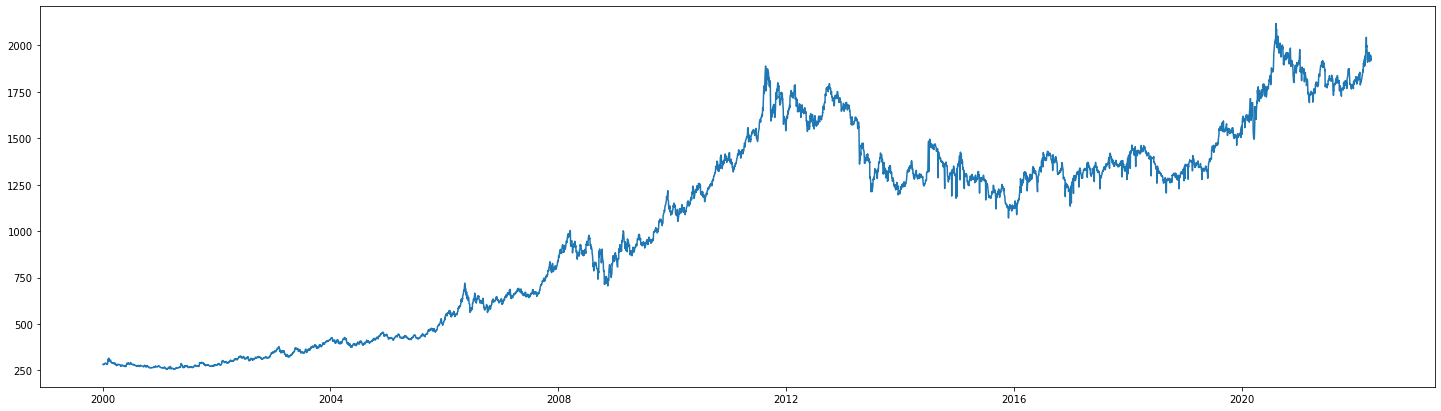

In [371]:
plt.figure(figsize=(25, 7))
plt.plot(Gold['Date'],Gold['Close'])
plt.show()

Cena złota rośnie z czasem. Widoczny szczyt w 2020 roku. 

Wykres dla miesiąca (marzec 2022).

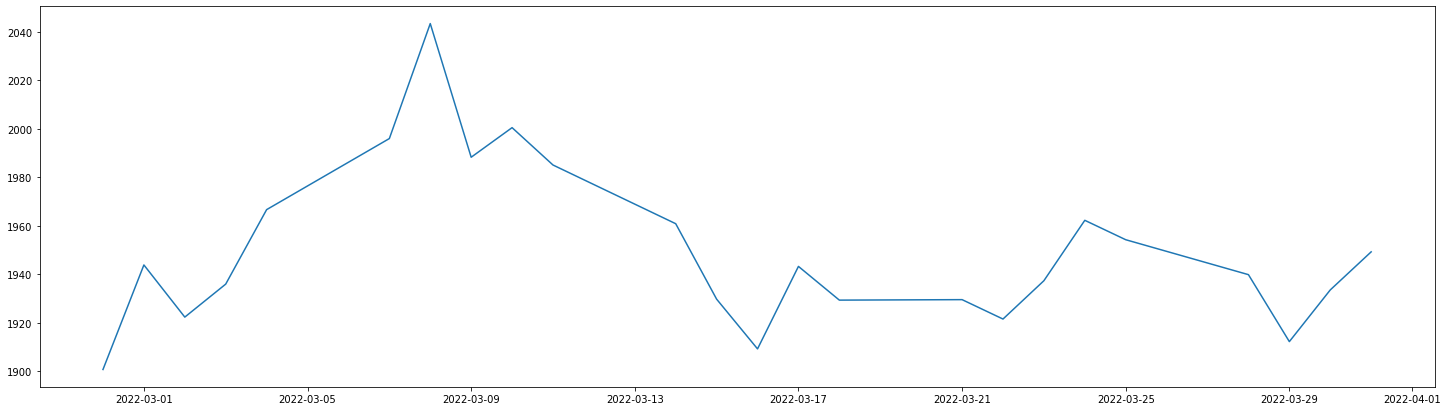

In [372]:
plt.figure(figsize=(25, 7))
plt.plot(Gold['Date'].iloc[-30:-6],Gold['Close'].iloc[-30:-6])
plt.show()

Skok i spadek w pierwszej połowie miesiąca, a później stabilizacja ceny. 

Dla całego okresy zwizualizujmy wykres świecowy. 

In [373]:
fig = go.Figure(data=
    [go.Candlestick(x=Gold['Date'],
                    open=Gold["Open"],
                    high=Gold["High"],
                    low=Gold["Low"],
                    close=Gold["Close"])]
)
 
fig.update_layout(
    title=f"Gold price in last 22 years",
    yaxis_title="Price ($)",
)
 
fig.show()

Modele będą zasilanie wskaźnikami analizy technicznej. Wskaźniki policzymy na podstawie parametrów dostarczonych ze zbioru tj. Open, High,     Low,        Close,        Volume

In [374]:
def indicators(High, Low, Close, Volume):

  RSI_14day= tb.RSI(Close, timeperiod=14)

  MA_14day = tb.MA(Close, timeperiod=14, matype=0)

  MACD, MACDsignal, MACDhist = tb.MACD(Close, fastperiod=12, slowperiod=26, signalperiod=9)

  ROC = tb.ROC(Close, timeperiod=14)

  ADX_14day = tb.ADX(High, Low, Close, timeperiod=14) 

  BBANDS_U_14day = tb.BBANDS(Close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[0] 

  BBANDS_M_14day = tb.BBANDS(Close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[1] 
                     
  BBANDS_L_14day = tb.BBANDS(Close, timeperiod=14, nbdevup=2, nbdevdn=2, matype=0)[2] 

  ATR_14day = tb.ATR(High, Low, Close, timeperiod=14)  
  

  return pd.DataFrame({'RSI_14day':RSI_14day ,'MA_14day': MA_14day, 'MACD':MACD,'MACDsignal':MACDsignal,'ROC':ROC, 'ADX_14day':ADX_14day, 'BBANDS_U_14day': BBANDS_U_14day, 
                      'BBANDS_M_14day': BBANDS_M_14day,'BBANDS_L_14day':BBANDS_L_14day, 'ATR_14day':ATR_14day})

Łączymy wszystkie parametry w jeden DF i tworzymy target.

In [375]:
X_Gold = indicators(Gold['High'], Gold['Low'], Gold['Close'],Gold['Volume'])
X_Gold= pd.merge(X_Gold,Gold,on=X_Gold.index)
X_Gold['tick']= ((X_Gold['Close'].shift(-1)- X_Gold["Close"])/X_Gold['Close'])*100
X_Gold.dropna(inplace=True)
X_Gold =X_Gold.drop('key_0', axis=1)
X_Gold.set_index(['Date'],inplace= True)
X_Gold


,RSI_14day,MA_14day,MACD,MACDsignal,ROC,ADX_14day,BBANDS_U_14day,BBANDS_M_14day,BBANDS_L_14day,ATR_14day,Symbol,Open,High,Low,Close,Volume,tick
Date,,,,,,,,,,,,,,,,,
2000-02-22,59.892611,302.992857,5.590922,5.660620,8.176991,37.184849,319.411220,302.992857,286.574494,5.396573,Gold,304.0,304.8,303.5,305.6,19,-1.701571
2000-02-23,53.747603,304.100000,5.065394,5.541574,5.440505,36.656797,317.254901,304.100000,290.945099,5.289675,Gold,303.0,303.0,301.7,300.4,18,-0.432756
2000-02-24,52.302831,304.950000,4.492226,5.331705,4.143454,36.166464,314.732711,304.950000,295.167289,5.040413,Gold,302.2,302.2,302.2,299.1,35,-2.039452
2000-02-25,46.047919,303.707143,3.505361,4.966436,-5.605670,34.538478,314.745120,303.707143,292.669166,4.851812,Gold,297.8,297.8,296.7,293.0,0,-0.170648
2000-02-28,45.566891,303.035714,2.652342,4.503617,-3.113614,32.230987,315.485065,303.035714,290.586364,4.555254,Gold,292.3,292.5,292.3,292.5,4,-0.034188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,47.747309,1933.564286,5.282879,10.990262,-2.126683,28.946767,1963.279372,1933.564286,1903.849200,36.523965,Gold,1935.0,1938.0,1917.0,1919.1,1016,0.526288
2022-04-04,49.718468,1933.528571,4.281210,9.648451,-0.025911,27.318977,1963.263345,1933.528571,1903.793798,35.379396,Gold,1921.2,1936.1,1915.6,1929.2,371,-0.326560
2022-04-05,48.489710,1934.507143,2.945073,8.307776,0.717578,26.092001,1961.774231,1934.507143,1907.240055,34.645153,Gold,1927.1,1943.5,1918.4,1922.9,412,-0.234022


# Przyjrzyjmy się nowo utowrzonym zmiennym 

**RSI** (Relative Strength Index)

Indeks Siły Względnej. Przy budowaniu zmiennej została ustawiona obserwacja dla 14 ostatnich świec. Jest to parametr z przedziału [0,100]. Widzimy, że wskźnik przekroczył próg 70 - wykupienie (jest to sytuacja, w której ceny gwałtownie wzrosły - bardziej niż oczekiwał tego rynek, a ruch może prawdopodobnie osłabnąć). Wskaźnik od początku roku nie spadł poniżej 30, nie było tzw. wyprzedania. 


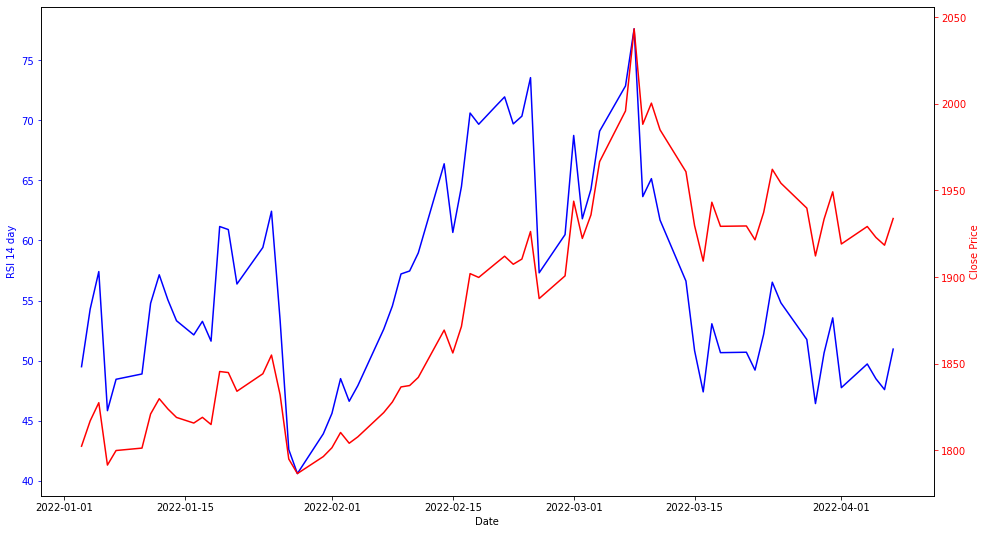

In [376]:
fig, ax = plt.subplots(figsize=(16, 9))


ax.plot(X_Gold.index[-71:5666],X_Gold['RSI_14day'][-71:5666], color='b')


ax.set_xlabel('Date')
ax.set_ylabel('RSI 14 day', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
ax2.plot(X_Gold.index[-71:5666],X_Gold['Close'][-71:5666], color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylabel('Close Price', color='r')
plt.show()

RSI = 50, w oparciu o niego można dokonywać transakcji kupna, gdy cena przechodzi od dołu przez ten poziom, lub sprzedaży, gdy cena przebija go od góry.

Dywergencji - jeżeli poszczególne wierzchołki cenowe znajdują się na coraz to wyższych poziomach podczas gdy na wskaźniku RSI te same punkty są opadające to sygnał do **sprzedaży** (połowa stycznia). Dla przypadku odwrotnego to sygnał do **kupna**. 

**MA** (Moving average) 

Średnia ruchoma (krocząca). Liczona jest jako średnia wartości cen (zazwyczaj zamknięcia) z określonego czasu.

Podstawowa analiza opiera się na przecięciach kursu przez średnią. Jeżeli notowania przebijają średnią od dołu otrzymujemy sygnał kupna (między 1/02, a 15/02). Przebicie średniej od góry identyfikowane jest jako sygnał sprzedaży (15/03).



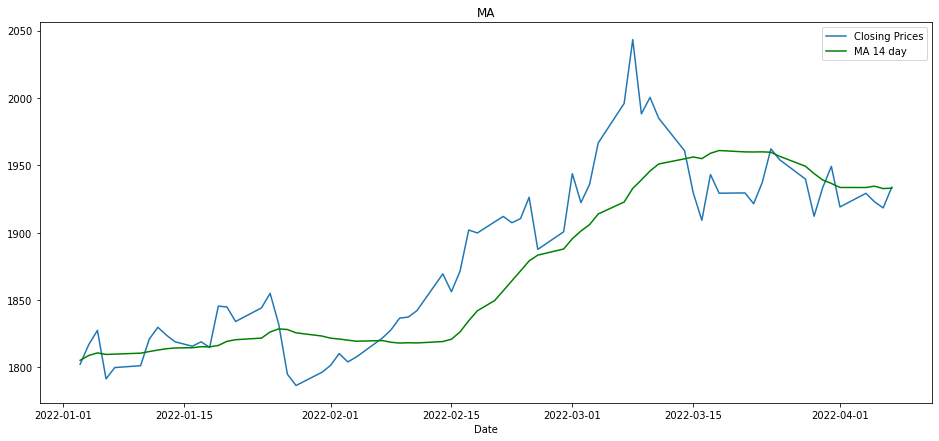

In [377]:
plt.figure(figsize=(16,7))
plt.title( 'MA')
plt.xlabel("Date")
plt.plot(X_Gold['Close'][-71:5666], label='Closing Prices')
plt.plot(X_Gold['MA_14day'][-71:5666], label='MA 14 day', c='g')
plt.legend()
plt.show()

**MACD** (Moving Average Convergence/Divergence)

Zbieżność/Rozbieżność średnich ruchomych. 

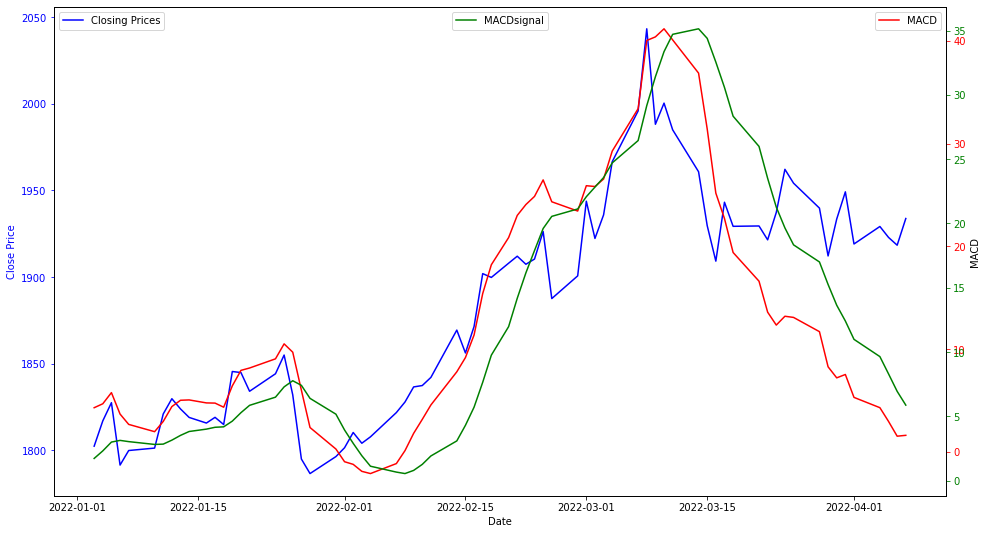

In [378]:
fig, ax = plt.subplots(figsize=(16, 9))


ax.plot(X_Gold.index[-71:5666],X_Gold['Close'][-71:5666],label='Closing Prices', color='b')

ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
ax2.plot(X_Gold.index[-71:5666],X_Gold['MACD'][-71:5666],label='MACD', color='r')
ax2.tick_params('y',colors='r')

ax2.set_ylabel('MACD')

ax3 = ax.twinx()
ax3.plot(X_Gold.index[-71:5666],X_Gold['MACDsignal'][-71:5666],label='MACDsignal', color='g')
ax3.tick_params('y',colors='g')


ax.legend( loc='upper left')
ax2.legend( loc='upper right')
ax3.legend( loc='upper center')
plt.show()

**MACD**  pokazuje różnicę pomiędzy 12-okresową MA a 26-okresową MA. Zatem MA to linia przecięcia średnich kroczących w jednej linii. Na wykresie została zaznaczona **MACDsignal** tzw. linia sygnału, jest to 9-okresowa MA wyznaczana z lini MACD \\
Przebicie od dołu linii wskaźnika przez linię sygnału oznacza sygnał kupna (01/03), zaś przebicie od góry linii wskaźnika jest sygnałem sprzedaży (początek lutego).

**ROC** (Rate Of Change) 



Wskaźnik zmiany (pędu/momentum) pokazuje, jak zmieniła się cena w wybranym okresie. 



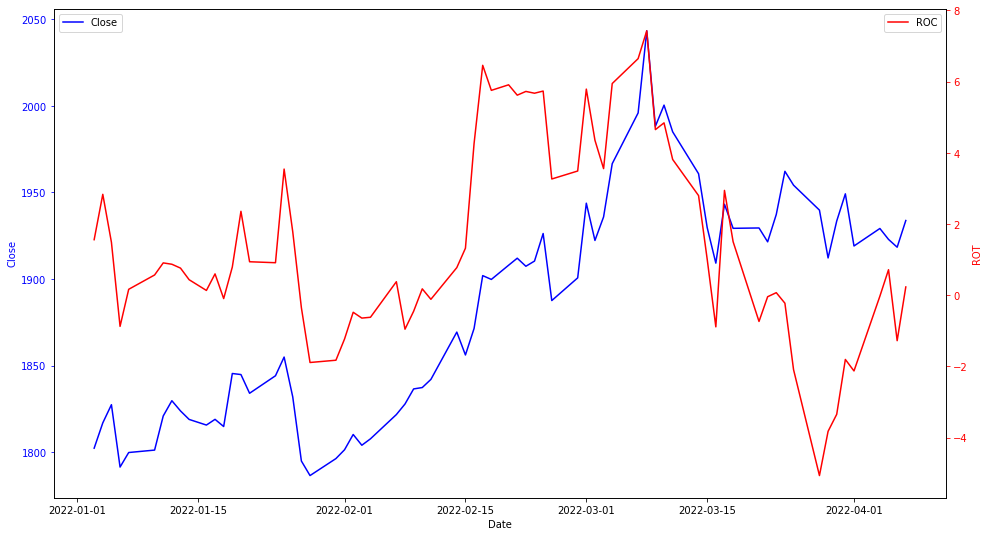

In [379]:
fig, ax = plt.subplots(figsize=(16, 9))


ax.plot(X_Gold.index[-71:5666],X_Gold['Close'][-71:5666], color='b', label='Close')


ax.set_xlabel('Date')
ax.set_ylabel('Close', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
ax2.plot(X_Gold.index[-71:5666],X_Gold['ROC'][-71:5666], color='r',label='ROC')
ax2.tick_params('y', colors='r')
ax2.set_ylabel('ROT', color='r')
ax.legend( loc='upper left')
ax2.legend( loc='upper right')
plt.show()


Jeśli wartość wskaźnika od dołu przetnie poziom zero jest to dobry moment kupna (15/03), zaś jeśli przetnie ten poziom od góry to jest to sygnał sprzedaży (koniec stycznia).

**ADX** (Average Directional Movement Index)

 Indeks średniego ruchu kierunkowego, wskaźnik określający trend oraz jego siłę. 
 
Wartość wskaźnika w przedziale [0,100] (bardzo rzadkim zjawiskiem jest przebicie wskaźnika > 60).



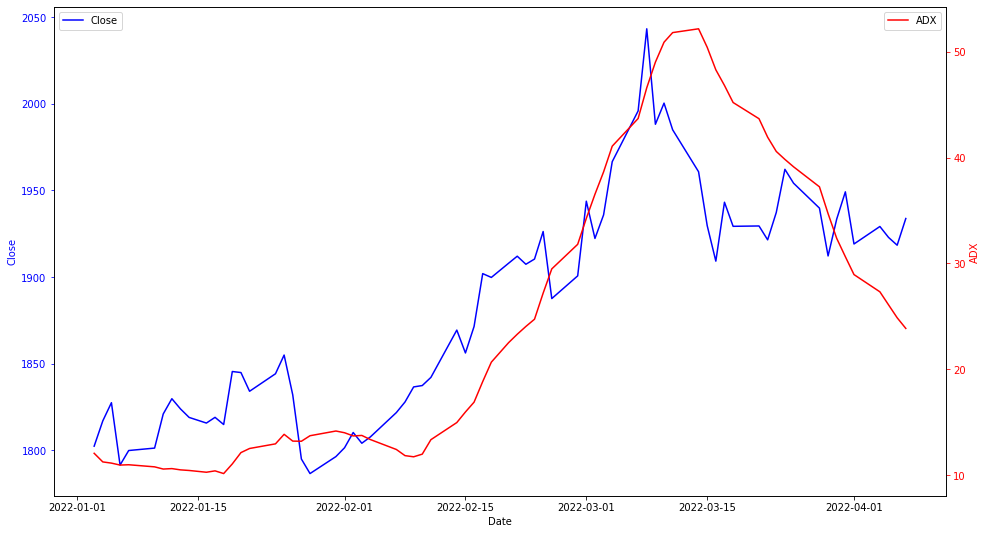

In [380]:
fig, ax = plt.subplots(figsize=(16, 9))


ax.plot(X_Gold.index[-71:5666],X_Gold['Close'][-71:5666], color='b', label='Close')


ax.set_xlabel('Date')
ax.set_ylabel('Close', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
ax2.plot(X_Gold.index[-71:5666],X_Gold['ADX_14day'][-71:5666], color='r',label='ADX')
ax2.tick_params('y', colors='r')
ax2.set_ylabel('ADX', color='r')
ax.legend( loc='upper left')
ax2.legend( loc='upper right')
plt.show()

Jeśli wartość wskaźnika jest niższa niż 20, przyjmuje się, że na rynku występuje trend boczny (konsolidacja). Gdy wartość jest wyższa niż 40, to znak, że na rynku występuje silny trend wzrostowy bądź spadkowy (początek marca).

**Bollinger bands** 

Wstęga Bollingera, wskaźnik zmienności cen. Najprostsza interpretacja to: Ruch cen powinien odbywać się wewnątrz ramion wstęgi.
Teoretycznie mała szerokość wskazuje na niższe ryzyko inwestycyjne i często poprzedza mocniejsze wybicie. Wyjście poza któreś z ramion powinno implikować dalszy ruch, chociaż w praktyce często następuje ruch powrotny do wnętrza wstęgi.

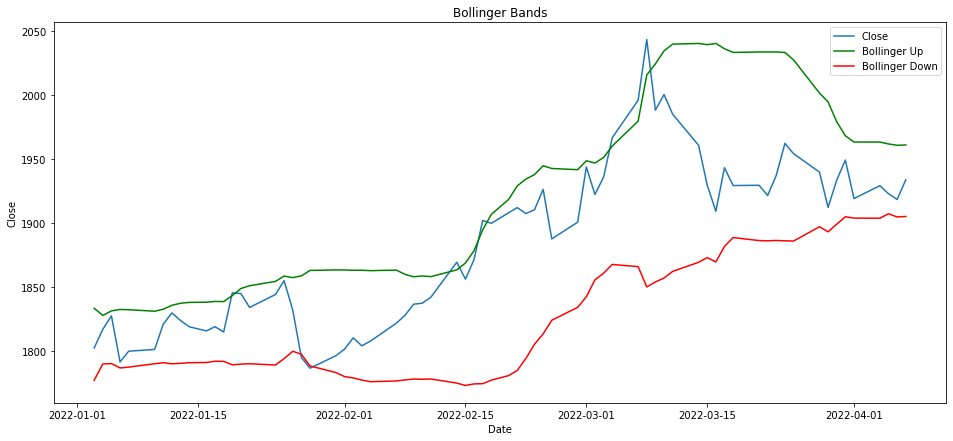

In [381]:
plt.figure(figsize=(16,7))
plt.title( 'Bollinger Bands')
plt.xlabel("Date")
plt.ylabel('Close')
plt.plot(X_Gold.index[-71:5666], X_Gold['Close'][-71:5666], label='Close')
plt.plot(X_Gold.index[-71:5666], X_Gold['BBANDS_U_14day'][-71:5666], label='Bollinger Up', c='g')
plt.plot(X_Gold.index[-71:5666], X_Gold['BBANDS_L_14day'][-71:5666], label='Bollinger Down', c='r')
plt.legend()
plt.show()

**ATR** (Average True Range)

Średni prawdziwy zakres zmiany, wskaźnik wykorzystywany do pomiaru zmienności cen. \\

Niskie wartości są widoczne w okresach konsolidcji. 

Wysokie wartości wskaźnika oznaczają duże zmiany na rynku i mają miejsce w momentach wybić, zmiany kierunku trendu lub wzrostu niepewności co do danego trendu (np. wzrost zmienności w ostatniej fazie hossy).

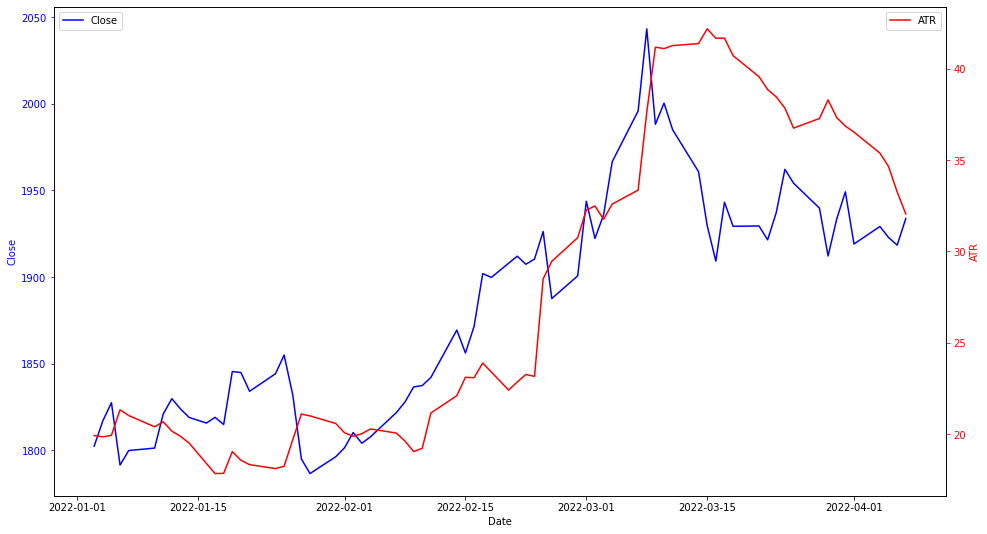

In [382]:
fig, ax = plt.subplots(figsize=(16, 9))


ax.plot(X_Gold.index[-71:5666],X_Gold['Close'][-71:5666], color='b', label='Close')


ax.set_xlabel('Date')
ax.set_ylabel('Close', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
ax2.plot(X_Gold.index[-71:5666],X_Gold['ATR_14day'][-71:5666], color='r',label='ATR')
ax2.tick_params('y', colors='r')
ax2.set_ylabel('ATR', color='r')
ax.legend( loc='upper left')
ax2.legend( loc='upper right')
plt.show()

Ponownie jak dla powyższych przypadków, widoczne zmiany były na początku marca.

**Tick**

Zmienna, którą przewidujemy. Określa o ile zmieni się cena zamknięcia w dniu jutrzejszym. 





/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



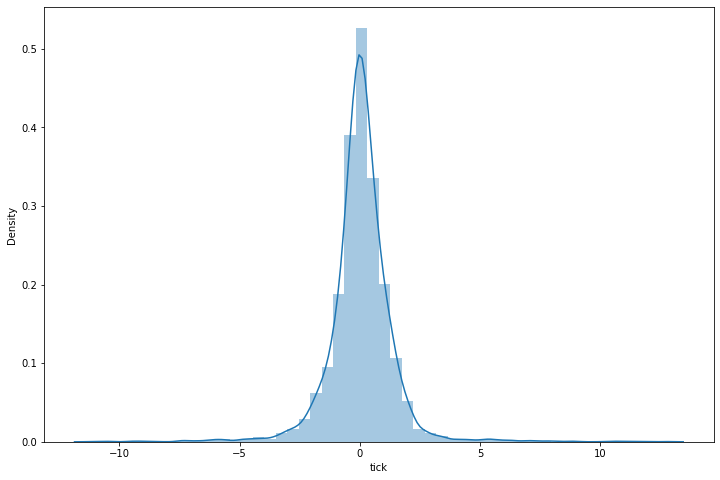

In [383]:
plt.figure(figsize=(12, 8))
sns.distplot(X_Gold['tick'])
plt.show()

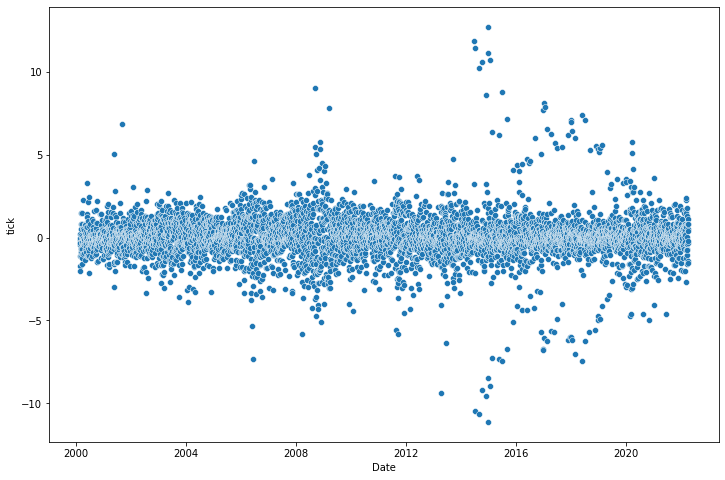

In [384]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Date', y='tick' ,data=X_Gold)
plt.show() 

Wyraźnie widać punkty odstające w 2015 roku, różnica cen osiąga swojeg min/max. 

Sprawdźmy korelację pomiędzy zmiennymi

In [385]:
corr_matrix = X_Gold.corr()
corr_matrix['tick']

RSI_14day        -0.079705
MA_14day         -0.015010
MACD             -0.050621
MACDsignal       -0.028921
ROC              -0.085174
ADX_14day         0.006367
BBANDS_U_14day   -0.013009
BBANDS_M_14day   -0.015010
BBANDS_L_14day   -0.017105
ATR_14day        -0.005401
Open             -0.019848
High             -0.019472
Low              -0.019426
Close            -0.021802
Volume           -0.000315
tick              1.000000
Name: tick, dtype: float64

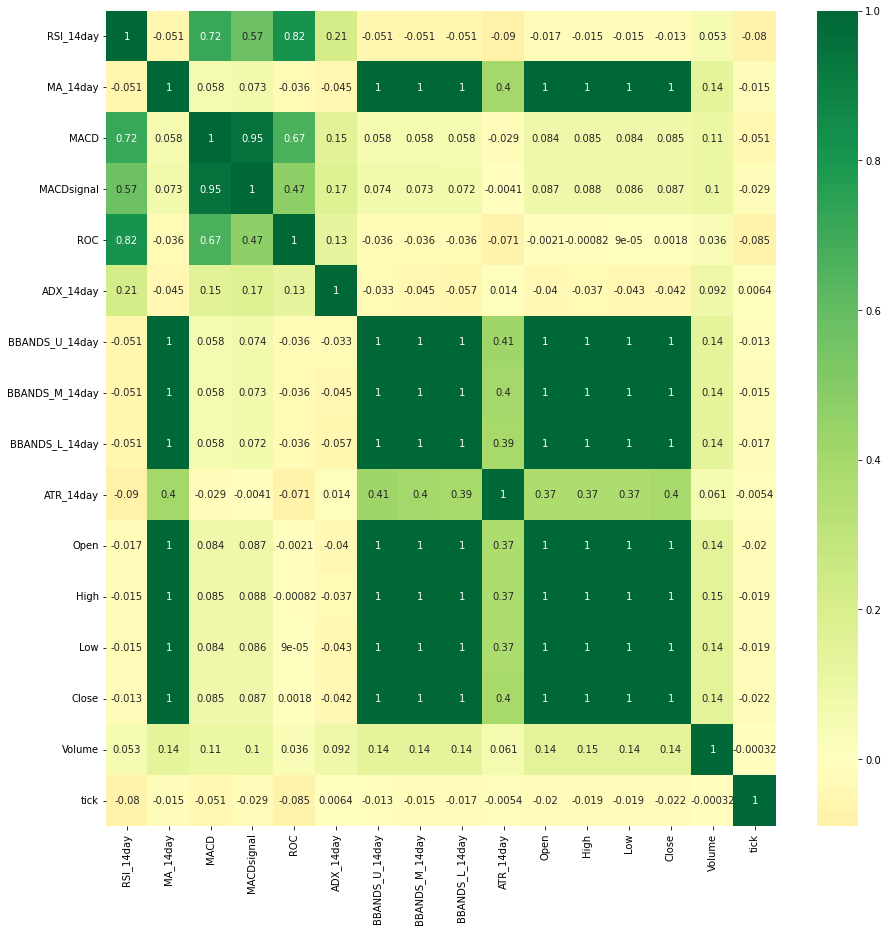

In [386]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(X_Gold.corr(), 
                 xticklabels=X_Gold.corr().columns, 
                 yticklabels=X_Gold.corr().columns, 
                 cmap='RdYlGn', 
                 center=0, 
                 annot=True)
plt.show()

Usuwamy zmienne na podstawie, których obliczyliśmy wskaźniki.

In [387]:
X_y = X_Gold.loc[:,['RSI_14day',	'MA_14day',	'MACD','MACDsignal','ROC','ADX_14day','BBANDS_U_14day','BBANDS_M_14day','BBANDS_L_14day',	'ATR_14day','tick']].copy()
X_y.dropna(inplace=True)
X_y

,RSI_14day,MA_14day,MACD,MACDsignal,ROC,ADX_14day,BBANDS_U_14day,BBANDS_M_14day,BBANDS_L_14day,ATR_14day,tick
Date,,,,,,,,,,,
2000-02-22,59.892611,302.992857,5.590922,5.660620,8.176991,37.184849,319.411220,302.992857,286.574494,5.396573,-1.701571
2000-02-23,53.747603,304.100000,5.065394,5.541574,5.440505,36.656797,317.254901,304.100000,290.945099,5.289675,-0.432756
2000-02-24,52.302831,304.950000,4.492226,5.331705,4.143454,36.166464,314.732711,304.950000,295.167289,5.040413,-2.039452
2000-02-25,46.047919,303.707143,3.505361,4.966436,-5.605670,34.538478,314.745120,303.707143,292.669166,4.851812,-0.170648
2000-02-28,45.566891,303.035714,2.652342,4.503617,-3.113614,32.230987,315.485065,303.035714,290.586364,4.555254,-0.034188
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,47.747309,1933.564286,5.282879,10.990262,-2.126683,28.946767,1963.279372,1933.564286,1903.849200,36.523965,0.526288
2022-04-04,49.718468,1933.528571,4.281210,9.648451,-0.025911,27.318977,1963.263345,1933.528571,1903.793798,35.379396,-0.326560
2022-04-05,48.489710,1934.507143,2.945073,8.307776,0.717578,26.092001,1961.774231,1934.507143,1907.240055,34.645153,-0.234022


In [388]:
corr_matrix = X_y.corr()
corr_matrix['tick']

RSI_14day        -0.079705
MA_14day         -0.015010
MACD             -0.050621
MACDsignal       -0.028921
ROC              -0.085174
ADX_14day         0.006367
BBANDS_U_14day   -0.013009
BBANDS_M_14day   -0.015010
BBANDS_L_14day   -0.017105
ATR_14day        -0.005401
tick              1.000000
Name: tick, dtype: float64

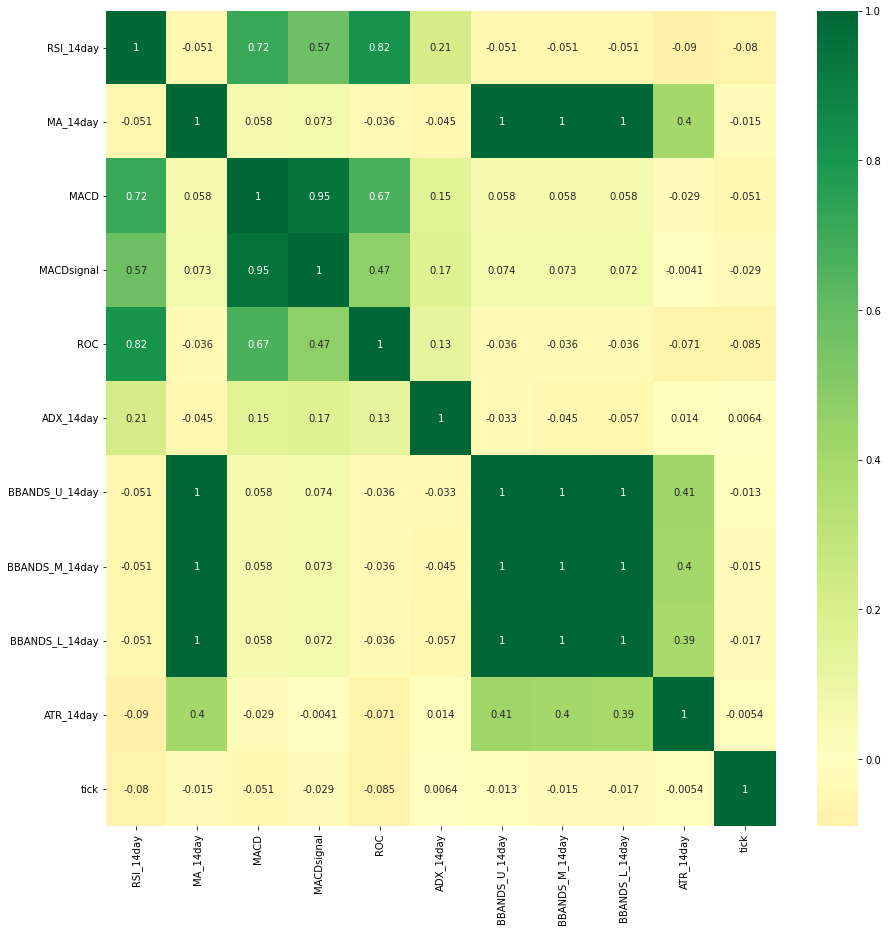

In [389]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(X_y.corr(), 
                 xticklabels=X_y.corr().columns, 
                 yticklabels=X_y.corr().columns, 
                 cmap='RdYlGn', 
                 center=0, 
                 annot=True)
plt.show()

# **Zbiór treningowy i testowy**
Podzielmy zbiór na **train** i **test**.

In [390]:
X_train = X_y.loc[X_y.index<'2022-01-01',:'ATR_14day']
X_test = X_y.loc[X_y.index>='2022-01-01',:'ATR_14day']
y_train = X_y.loc[X_y.index<'2022-01-01','tick']
y_test = X_y.loc[X_y.index>='2022-01-01','tick']

print()
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')


X_train.shape: (5594, 10), y_train.shape: (5594,)
X_test.shape: (71, 10), y_test.shape: (71,)


In [391]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

# **Dummy Model**
Stwórzmy prosty model, który będzie prognozował medianę ze zbioru treningowego.

In [392]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(X_train_scaler, y_train)

DummyRegressor(strategy='median')

In [393]:
y_train_dummy = dummy_model.predict(X_train_scaler)
y_test_dummy = dummy_model.predict(X_test_scaler)

# **Regression Model**

In [394]:
lr_model = LinearRegression() 
lr_model.fit(X_train_scaler, y_train) 

LinearRegression()

In [395]:
y_predict_train = lr_model.predict(X_train_scaler)
y_predict_test = lr_model.predict(X_test_scaler)

# **Wybór hiperparametrów**






Regresja wielomianowa

In [396]:
transformer = Pipeline(steps=[
    ('log_transformer', PowerTransformer()),
    ('scalar', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer, X_train.columns )])

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])

In [397]:
params = {'preprocessor__num__polynomialfeatures__degree':[1,2,3,4,5,6]}
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
polynomial_regression_gridsearch = GridSearchCV(final_pipeline, #tutaj wskazujemy jaki tym regresji
                                                params, 
                                                scoring = 'neg_mean_squared_error', 
                                                cv = my_cv, 
                                                verbose= 10)
polynomial_regression_gridsearch.fit(X_train, y_train)
print('\nBest hypermarameter: ', polynomial_regression_gridsearch.best_params_)
polynomial_model = polynomial_regression_gridsearch.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............
[CV 1/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-1.240 total time=   0.1s
[CV 2/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............
[CV 2/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-2.083 total time=   0.1s
[CV 3/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............
[CV 3/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-2.451 total time=   0.2s
[CV 4/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 4/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-3.315 total time=   0.2s
[CV 5/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............
[CV 5/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-1.551 total time=   0.2s
[CV 1/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 1/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-18.791 total time=   0.1s
[CV 2/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 2/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-4.399 total time=   0.2s
[CV 3/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 3/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-2.630 total time=   0.2s
[CV 4/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 4/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-3.275 total time=   0.2s
[CV 5/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 5/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-1.595 total time=   0.2s
[CV 1/5; 3/6] START preprocessor__num__polynomialfeatures__degree=3.............
[CV 1/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-7392.243 total time=   0.3s
[CV 2/5; 3/6] START preprocessor__num__polynomialfeatures__degree=3.............
[CV 2/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-713.777 total time=   0.3s
[CV 3/5; 3/6] START preprocessor__num__polynomialfeatures__degree=3.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 3/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-8.150 total time=   0.4s
[CV 4/5; 3/6] START preprocessor__num__polynomialfeatures__degree=3.............
[CV 4/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-5.220 total time=   0.4s
[CV 5/5; 3/6] START preprocessor__num__polynomialfeatures__degree=3.............
[CV 5/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-2.321 total time=   0.5s
[CV 1/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............
[CV 1/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-332712739.333 total time=   0.9s
[CV 2/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............
[CV 2/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-694016.726 total time=   1.6s
[CV 3/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 3/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-522.766 total time=   1.8s
[CV 4/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............
[CV 4/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-19.874 total time=   2.2s
[CV 5/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............
[CV 5/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-37.207 total time=   2.3s
[CV 1/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............
[CV 1/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-1485852124.943 total time=   2.3s
[CV 2/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............
[CV 2/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-39036146080.030 total time=   9.2s
[CV 3/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 3/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-6546.083 total time=  23.0s
[CV 4/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............
[CV 4/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-2262.895 total time=  23.5s
[CV 5/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............
[CV 5/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-6202.812 total time=  24.4s
[CV 1/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............
[CV 1/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-33177148493.386 total time=   2.4s
[CV 2/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............
[CV 2/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-16332297729.488 total time=   7.4s
[CV 3/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 3/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-10183248.306 total time=  18.9s
[CV 4/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............
[CV 4/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-32277201.814 total time=  39.6s
[CV 5/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............
[CV 5/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-993410752.869 total time= 1.1min

Best hypermarameter:  {'preprocessor__num__polynomialfeatures__degree': 1}


In [398]:
y_predict_polynomial_best = polynomial_model.predict(X_test)


Drzewo decyzyjne

In [399]:
model_tree = DecisionTreeRegressor()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [1, 2, 3, 4, 5, 6],
          'min_samples_leaf': [2,3,5,10,50,100]}
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
model_tree_gridsearch = GridSearchCV(model_tree, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=my_cv,
                                                verbose=10)

model_tree_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', model_tree_gridsearch.best_params_)

model_tree = model_tree_gridsearch.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 1/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-1.270 total time=   0.0s
[CV 2/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 2/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-10.697 total time=   0.0s
[CV 3/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 3/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-2.777 total time=   0.0s
[CV 4/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 4/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-3.284 total time=   0.0s
[CV 5/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 5/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-1.507 total time=   0.0s
[CV 1/5; 2/36] START max_depth=1, min_samples_leaf=3............................
[CV 1/5; 2/36] END max_dep

In [400]:
y_predict_tree_best = model_tree.predict(X_test)


Las losowy

In [401]:
model_forest = RandomForestRegressor()

params = [{'n_estimators':[3,10], 
          'max_features':[2, 4,6,8]},
          {'bootstrap':[False],
          'n_estimators':[3,10],
           'max_features':[2, 4,6,8]},]
        
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
model_forest_gridsearch = GridSearchCV(model_forest, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=my_cv,
                                                verbose=10)

model_forest_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', model_forest_gridsearch.best_params_)

model_forest = model_forest_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START max_features=2, n_estimators=3.............................
[CV 1/5; 1/16] END max_features=2, n_estimators=3;, score=-2.091 total time=   0.0s
[CV 2/5; 1/16] START max_features=2, n_estimators=3.............................
[CV 2/5; 1/16] END max_features=2, n_estimators=3;, score=-5.542 total time=   0.0s
[CV 3/5; 1/16] START max_features=2, n_estimators=3.............................
[CV 3/5; 1/16] END max_features=2, n_estimators=3;, score=-3.259 total time=   0.0s
[CV 4/5; 1/16] START max_features=2, n_estimators=3.............................
[CV 4/5; 1/16] END max_features=2, n_estimators=3;, score=-4.204 total time=   0.1s
[CV 5/5; 1/16] START max_features=2, n_estimators=3.............................
[CV 5/5; 1/16] END max_features=2, n_estimators=3;, score=-2.925 total time=   0.1s
[CV 1/5; 2/16] START max_features=2, n_estimators=10............................
[CV 1/5; 2/16] END max_features=2

In [402]:
y_predict_forest_best = model_forest.predict(X_test)


Regresor AdaBoost

In [403]:
parameters = {
              'n_estimators': [1, 10,30, 100, 200,500]
              
              }
model_adaboost = AdaBoostRegressor()
searcher = GridSearchCV(model_adaboost, parameters, n_jobs=-1)
searcher.fit(X_train, y_train)
print('\nBest hyperparameter:', searcher.best_params_)
ada_boost_model = searcher.best_estimator_


Best hyperparameter: {'n_estimators': 1}


In [404]:
y_predict_adaboost_best = ada_boost_model.predict(X_test)

Wyniki predykcji dla najlepszych hiperparametrów.   


In [405]:
print("MAE")
print(f'Dummy: {round(mean_absolute_error(y_test, y_test_dummy),2)}')
print(f'Linear: {round(mean_absolute_error(y_test, y_predict_test),2)}')
print(f'Model polynomial, best hypermarameter polynomial features degree = 1 : {round(mean_absolute_error(y_test, y_predict_polynomial_best),2)}')
print(f'Model tree, best hyperparameter max_depth = 4, min_samples_leaf = 100: {round(mean_absolute_error(y_test, y_predict_tree_best),2)}')
print(f'Model forest, best hyperparameter, max_features= 2, n_estimators = 10: {round(mean_absolute_error(y_test, y_predict_forest_best),2)}')
print(f'Model adaboost, best hyperparameter, n_estimators = 10: {round(mean_absolute_error(y_test, y_predict_adaboost_best),2)}')

MAE
Dummy: 0.81
Linear: 0.83
Model polynomial, best hypermarameter polynomial features degree = 1 : 0.85
Model tree, best hyperparameter max_depth = 4, min_samples_leaf = 100: 0.81
Model forest, best hyperparameter, max_features= 2, n_estimators = 10: 0.91
Model adaboost, best hyperparameter, n_estimators = 10: 0.8


## **Wizualizacyjna ocena modelu** 

In [406]:
def visualization_of_the_results(predict):

  
  plt.scatter(x = predict, y = y_test, alpha=0.25)

  xmin, xmax = y_test.min(), y_test.max()
  x_line = np.linspace(xmin, xmax, 10)
  y_line = x_line
  # Oczekiwana linia trendu
  plt.plot(x_line, y_line, 'r--')

  plt.xlabel('Prediction')
  plt.ylabel('True value')
  plt.title('Plot of predicted values versus true values')
  plt.show()

  
  errors = predict - y_test
  plt.scatter(x = y_test, y= errors, alpha=0.25)
  plt.axhline(0, color='r', linestyle='--')
  plt.xlabel('True values')
  plt.ylabel('Residuals')
  plt.title('Plot of residuals')
  plt.show()

  
  print(f'Error mean: {errors.mean()}')

  plt.hist(errors, bins=20)
  plt.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
  plt.title('Histogram of residuals')
  plt.show()

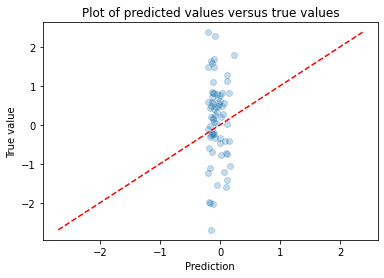

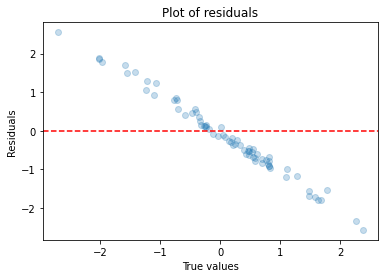

Error mean: -0.1665400693178987


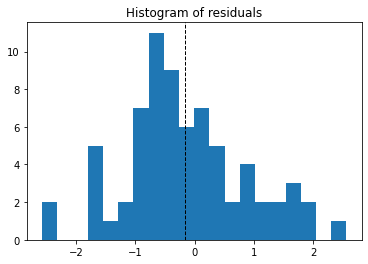

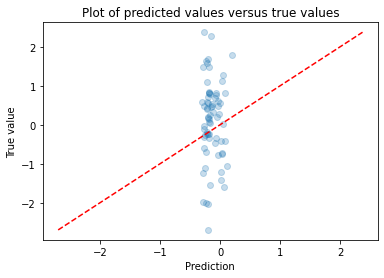

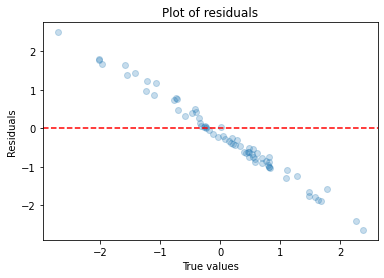

Error mean: -0.245555023222916


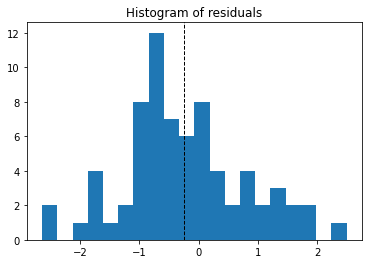

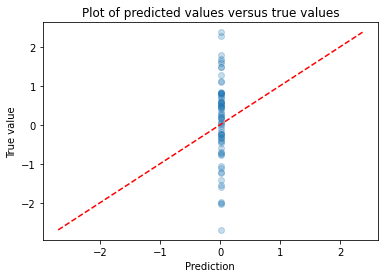

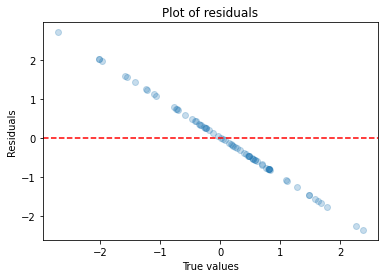

Error mean: -0.09210945254824776


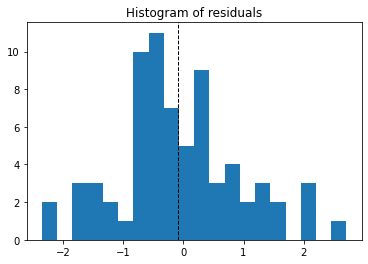

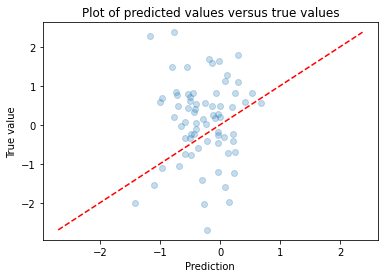

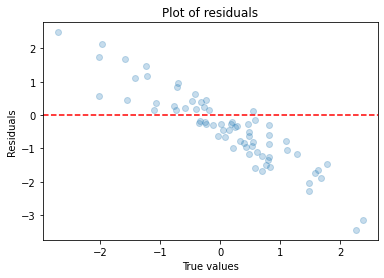

Error mean: -0.39175240864464383


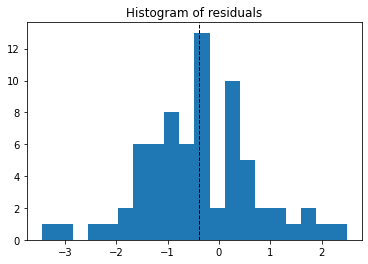

In [407]:
visualization_of_the_results(y_predict_test)
visualization_of_the_results(y_predict_polynomial_best)
visualization_of_the_results(y_predict_tree_best)
visualization_of_the_results(y_predict_forest_best)

Dla naszego targetu wybierzmy wartości dla których różnica ceny zamknięcia osiąga swoje największe skoki (wybierzmy 5% wartości min i max), reszta danych zostanie usunięta.

In [408]:
tick5_min_max =  X_y.copy

In [409]:
tick5_min_max = X_y.sort_values(by=['tick'], ascending=True)
tick5_min_max.head()

,RSI_14day,MA_14day,MACD,MACDsignal,ROC,ADX_14day,BBANDS_U_14day,BBANDS_M_14day,BBANDS_L_14day,ATR_14day,tick
Date,,,,,,,,,,,
2014-12-31,54.763102,1296.778571,-4.134398,-6.534585,-0.514043,17.764787,1369.283002,1296.778571,1224.274141,108.919846,-11.127752
2014-08-29,48.330054,1447.821429,-0.421702,3.067167,-1.699079,14.804450,1473.650668,1447.821429,1421.992189,145.663348,-10.613633
2014-07-03,86.539422,1354.342857,47.881124,25.615536,15.851456,31.492134,1515.845669,1354.342857,1192.840045,40.932120,-10.456763
2014-11-26,49.486552,1301.864286,-5.956045,-11.160647,3.962354,14.284917,1330.016789,1301.864286,1273.711782,127.351288,-9.562571
2013-04-12,28.848565,1574.164286,-15.718442,-10.332793,-6.549620,26.009822,1628.477063,1574.164286,1519.851509,21.603923,-9.353764


In [410]:
tick5_min_max['Number']= range(0,5665,1)


In [411]:
tick5_min = tick5_min_max.loc[tick5_min_max['Number']<565,:]
tick5_beetwen = tick5_min_max.loc[(tick5_min_max['Number']>=565)&(tick5_min_max['Number']<5100),:]
tick5_max = tick5_min_max.loc[tick5_min_max['Number']>=5100,:]


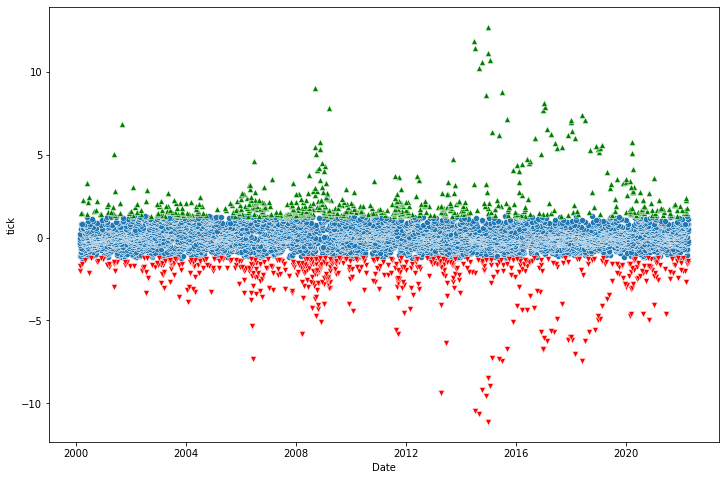

In [412]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tick5_beetwen.index, y='tick' ,data=tick5_beetwen)
sns.scatterplot(x=tick5_min.index, y='tick' ,data=tick5_min,marker='v', color='r')
sns.scatterplot(x=tick5_max.index, y='tick' ,data=tick5_max,marker='^', color='g')
plt.show() 

In [413]:
toogether_tick5minmax = pd.concat([tick5_min,tick5_max])
toogether_tick5minmax  

,RSI_14day,MA_14day,MACD,MACDsignal,ROC,ADX_14day,BBANDS_U_14day,BBANDS_M_14day,BBANDS_L_14day,ATR_14day,tick,Number
Date,,,,,,,,,,,,
2014-12-31,54.763102,1296.778571,-4.134398,-6.534585,-0.514043,17.764787,1369.283002,1296.778571,1224.274141,108.919846,-11.127752,0
2014-08-29,48.330054,1447.821429,-0.421702,3.067167,-1.699079,14.804450,1473.650668,1447.821429,1421.992189,145.663348,-10.613633,1
2014-07-03,86.539422,1354.342857,47.881124,25.615536,15.851456,31.492134,1515.845669,1354.342857,1192.840045,40.932120,-10.456763,2
2014-11-26,49.486552,1301.864286,-5.956045,-11.160647,3.962354,14.284917,1330.016789,1301.864286,1273.711782,127.351288,-9.562571,3
2013-04-12,28.848565,1574.164286,-15.718442,-10.332793,-6.549620,26.009822,1628.477063,1574.164286,1519.851509,21.603923,-9.353764,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-19,43.536335,1340.542857,7.424984,12.224142,-4.455594,20.281919,1450.726048,1340.542857,1230.359666,59.780567,10.698331,5660
2014-12-25,25.816952,1304.242857,-15.138684,-4.311499,-10.207507,15.610969,1385.965129,1304.242857,1222.520585,121.402661,11.104503,5661
2014-07-04,47.435884,1357.657143,38.973151,28.287059,3.639501,31.078211,1514.335097,1357.657143,1200.979189,49.151255,11.405434,5662


In [414]:
toogether_tick5minmax = toogether_tick5minmax.sort_values(by=['Date'], ascending=True)
toogether_tick5minmax=toogether_tick5minmax.drop('Number', axis=1)

In [415]:
toogether_tick5minmax['Number']= range(0,1130,1)


In [416]:
toogether_tick5minmax

,RSI_14day,MA_14day,MACD,MACDsignal,ROC,ADX_14day,BBANDS_U_14day,BBANDS_M_14day,BBANDS_L_14day,ATR_14day,tick,Number
Date,,,,,,,,,,,,
2000-02-22,59.892611,302.992857,5.590922,5.660620,8.176991,37.184849,319.411220,302.992857,286.574494,5.396573,-1.701571,0
2000-02-24,52.302831,304.950000,4.492226,5.331705,4.143454,36.166464,314.732711,304.950000,295.167289,5.040413,-2.039452,1
2000-03-06,40.937690,296.442857,-0.580601,1.707977,-6.677472,23.967430,308.860291,296.442857,284.025424,3.508878,1.493574,2
2000-03-20,41.366838,288.585714,-2.218066,-1.326881,-2.325581,15.662101,292.953033,288.585714,284.218396,2.769465,1.470588,3
2000-03-24,41.554109,287.928571,-2.151595,-1.740816,-1.111497,13.792740,292.778566,287.928571,283.078577,2.629011,-1.615736,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-08,77.622986,1932.860714,40.034096,29.163931,7.429022,46.585916,2015.620834,1932.860714,1850.100595,37.611134,-2.696618,1125
2022-03-14,56.621900,1954.800000,36.855418,35.136161,2.799623,52.152412,2040.264078,1954.800000,1869.335922,41.372139,-1.586087,1126
2022-03-16,47.394782,1954.957143,25.168931,32.548205,-0.887712,48.279490,2040.296456,1954.957143,1869.617830,41.661181,1.780851,1127


# **Zbiór treningowy i testowy**


In [417]:
X_train = toogether_tick5minmax.loc[toogether_tick5minmax['Number']<905,:'ATR_14day']
X_test = toogether_tick5minmax.loc[toogether_tick5minmax['Number']>=905,:'ATR_14day']
y_train = toogether_tick5minmax.loc[toogether_tick5minmax['Number']<905,'tick']
y_test = toogether_tick5minmax.loc[toogether_tick5minmax['Number']>=905,'tick']

print()
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')


X_train.shape: (905, 10), y_train.shape: (905,)
X_test.shape: (225, 10), y_test.shape: (225,)


In [418]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

# **Dummy Model**

In [419]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(X_train_scaler, y_train)

DummyRegressor(strategy='median')

In [420]:
y_train_dummy = dummy_model.predict(X_train_scaler)
y_test_dummy = dummy_model.predict(X_test_scaler)

# **Regression Model**

In [421]:
lr_model = LinearRegression() 
lr_model.fit(X_train_scaler, y_train) 

LinearRegression()

In [422]:
y_predict_train = lr_model.predict(X_train_scaler)
y_predict_test = lr_model.predict(X_test_scaler)

# **Wybór hiperparametrów**

In [423]:
transformer = Pipeline(steps=[
    ('log_transformer', PowerTransformer()),
    ('scalar', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer, X_train.columns )])

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])

In [424]:
params = {'preprocessor__num__polynomialfeatures__degree':[1,2,3,4,5,6]}
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
polynomial_regression_gridsearch = GridSearchCV(final_pipeline, #tutaj wskazujemy jaki tym regresji
                                                params, 
                                                scoring = 'neg_mean_squared_error', 
                                                cv = my_cv, 
                                                verbose= 10)
polynomial_regression_gridsearch.fit(X_train, y_train)
print('\nBest hypermarameter: ', polynomial_regression_gridsearch.best_params_)
polynomial_model = polynomial_regression_gridsearch.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............
[CV 1/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-8.648 total time=   0.1s
[CV 2/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............
[CV 2/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-7.952 total time=   0.0s
[CV 3/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............
[CV 3/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-4.799 total time=   0.0s
[CV 4/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............
[CV 4/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-6.236 total time=   0.0s
[CV 5/5; 1/6] START preprocessor__num__polynomialfeatures__degree=1.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 5/5; 1/6] END preprocessor__num__polynomialfeatures__degree=1;, score=-19.202 total time=   0.0s
[CV 1/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 1/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-214.147 total time=   0.1s
[CV 2/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 2/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-67.055 total time=   0.1s
[CV 3/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 3/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-18.620 total time=   0.1s
[CV 4/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 4/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-28.387 total time=   0.1s
[CV 5/5; 2/6] START preprocessor__num__polynomialfeatures__degree=2.............
[CV 5/5; 2/6] END preprocessor__num__polynomialfeatures__degree=2;, score=-21.620 total t

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 2/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-1058902.714 total time=   0.1s
[CV 3/5; 3/6] START preprocessor__num__polynomialfeatures__degree=3.............
[CV 3/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-23816.588 total time=   0.1s
[CV 4/5; 3/6] START preprocessor__num__polynomialfeatures__degree=3.............
[CV 4/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-1071.911 total time=   0.1s
[CV 5/5; 3/6] START preprocessor__num__polynomialfeatures__degree=3.............
[CV 5/5; 3/6] END preprocessor__num__polynomialfeatures__degree=3;, score=-942.375 total time=   0.1s
[CV 1/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............
[CV 1/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-44534060.527 total time=   0.1s
[CV 2/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 2/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-3108991.501 total time=   0.1s
[CV 3/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............
[CV 3/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-856308.575 total time=   0.2s
[CV 4/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............
[CV 4/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-122230125.051 total time=   0.3s
[CV 5/5; 4/6] START preprocessor__num__polynomialfeatures__degree=4.............
[CV 5/5; 4/6] END preprocessor__num__polynomialfeatures__degree=4;, score=-6416182.098 total time=   0.4s
[CV 1/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............
[CV 1/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-98148418.158 total time=   0.2s
[CV 2/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 2/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-8076246.480 total time=   0.3s
[CV 3/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............
[CV 3/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-1651486.942 total time=   0.4s
[CV 4/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............
[CV 4/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-13503974.441 total time=   0.5s
[CV 5/5; 5/6] START preprocessor__num__polynomialfeatures__degree=5.............
[CV 5/5; 5/6] END preprocessor__num__polynomialfeatures__degree=5;, score=-78507807.937 total time=   0.7s
[CV 1/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning:

divide by zero encountered in log



[CV 1/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-5320912669.064 total time=   0.3s
[CV 2/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............
[CV 2/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-9369351.545 total time=   0.5s
[CV 3/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............
[CV 3/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-6405225.077 total time=   0.7s
[CV 4/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............
[CV 4/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-101653749.048 total time=   1.2s
[CV 5/5; 6/6] START preprocessor__num__polynomialfeatures__degree=6.............
[CV 5/5; 6/6] END preprocessor__num__polynomialfeatures__degree=6;, score=-87151089.443 total time=   1.6s

Best hypermarameter:  {'preprocessor__num__polynomialfeatures__degree': 1}


In [425]:
y_predict_polynomial_best = polynomial_model.predict(X_test)

In [426]:
model_tree = DecisionTreeRegressor()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [1, 2, 3, 4, 5, 6],
          'min_samples_leaf': [2,3,5,10,50,200]}
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
model_tree_gridsearch = GridSearchCV(model_tree, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=my_cv,
                                                verbose=10)

model_tree_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', model_tree_gridsearch.best_params_)

model_tree = model_tree_gridsearch.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 1/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-5.749 total time=   0.0s
[CV 2/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 2/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-6.542 total time=   0.0s
[CV 3/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 3/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-4.688 total time=   0.0s
[CV 4/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 4/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-6.317 total time=   0.0s
[CV 5/5; 1/36] START max_depth=1, min_samples_leaf=2............................
[CV 5/5; 1/36] END max_depth=1, min_samples_leaf=2;, score=-19.238 total time=   0.0s
[CV 1/5; 2/36] START max_depth=1, min_samples_leaf=3............................
[CV 1/5; 2/36] END max_dep

In [427]:
y_predict_tree_best = model_tree.predict(X_test)

In [428]:
model_forest = RandomForestRegressor()

params = [{'n_estimators':[3,10,15], 
          'max_features':[2, 4,6,8]},
          {'bootstrap':[False],
          'n_estimators':[3,10,15],
           'max_features':[2, 4,6,8]},]
        
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
model_forest_gridsearch = GridSearchCV(model_forest, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=my_cv,
                                                verbose=10)

model_forest_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', model_forest_gridsearch.best_params_)

model_forest = model_forest_gridsearch.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START max_features=2, n_estimators=3.............................
[CV 1/5; 1/24] END max_features=2, n_estimators=3;, score=-8.754 total time=   0.0s
[CV 2/5; 1/24] START max_features=2, n_estimators=3.............................
[CV 2/5; 1/24] END max_features=2, n_estimators=3;, score=-16.223 total time=   0.0s
[CV 3/5; 1/24] START max_features=2, n_estimators=3.............................
[CV 3/5; 1/24] END max_features=2, n_estimators=3;, score=-6.560 total time=   0.0s
[CV 4/5; 1/24] START max_features=2, n_estimators=3.............................
[CV 4/5; 1/24] END max_features=2, n_estimators=3;, score=-7.980 total time=   0.0s
[CV 5/5; 1/24] START max_features=2, n_estimators=3.............................
[CV 5/5; 1/24] END max_features=2, n_estimators=3;, score=-22.133 total time=   0.0s
[CV 1/5; 2/24] START max_features=2, n_estimators=10............................
[CV 1/5; 2/24] END max_feature

In [429]:
y_predict_forest_best = model_forest.predict(X_test)

In [430]:
parameters = {
              'n_estimators': [1, 10,30, 100, 200,500]
              
              }
model_adaboost = AdaBoostRegressor()
searcher = GridSearchCV(model_adaboost, parameters, n_jobs=-1)
searcher.fit(X_train, y_train)
print('\nBest hyperparameter:', searcher.best_params_)
ada_boost_model = searcher.best_estimator_


Best hyperparameter: {'n_estimators': 10}


In [431]:
y_predict_adaboost_best = ada_boost_model.predict(X_test)

In [432]:
print("MAE")
print(f'Dummy: {round(mean_absolute_error(y_test, y_test_dummy),2)}')
print(f'Linear: {round(mean_absolute_error(y_test, y_predict_test),2)}')
print(f'Model polynomial, best hypermarameter polynomial features degree = 1 : {round(mean_absolute_error(y_test, y_predict_polynomial_best),2)}')
print(f'Model tree, best hyperparameter max_depth = 1, min_samples_leaf = 200: {round(mean_absolute_error(y_test, y_predict_tree_best),2)}')
print(f'Model forest, best hyperparameter, max_features= 6, n_estimators = 15: {round(mean_absolute_error(y_test, y_predict_forest_best),2)}')
print(f'Model adaboost, best hyperparameter, n_estimators = 10: {round(mean_absolute_error(y_test, y_predict_adaboost_best),2)}')

MAE
Dummy: 2.79
Linear: 2.68
Model polynomial, best hypermarameter polynomial features degree = 1 : 2.66
Model tree, best hyperparameter max_depth = 1, min_samples_leaf = 200: 2.72
Model forest, best hyperparameter, max_features= 6, n_estimators = 15: 2.67
Model adaboost, best hyperparameter, n_estimators = 10: 2.73


## **Wizualizacyjna ocena modelu** 

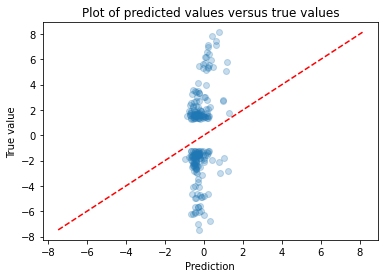

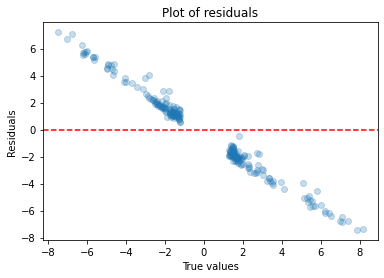

Error mean: -0.2154013130258451


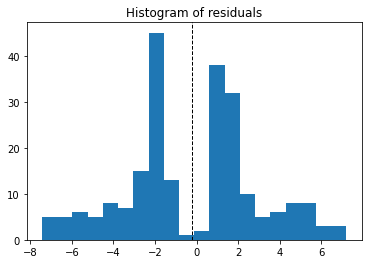

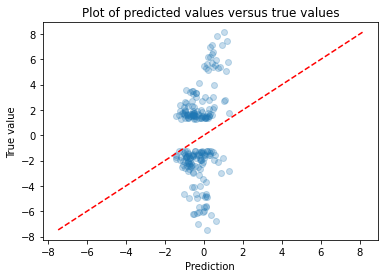

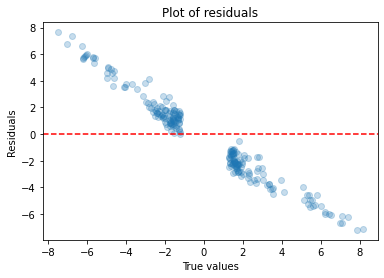

Error mean: -0.28599007907031787


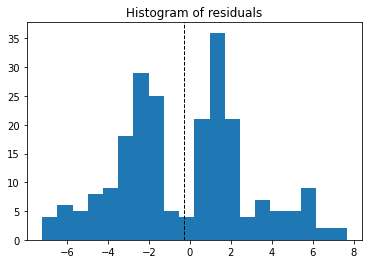

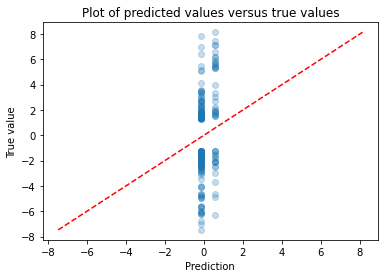

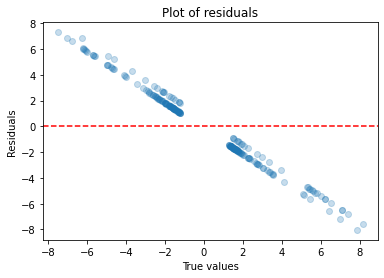

Error mean: -0.009269195043816356


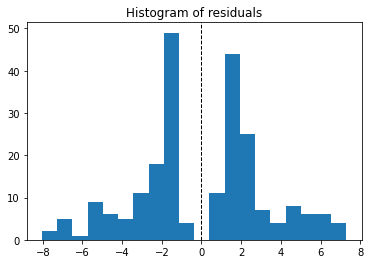

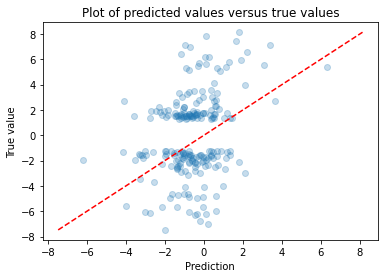

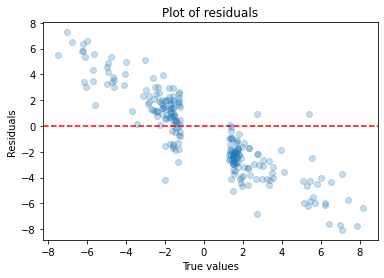

Error mean: -0.5877517379534628


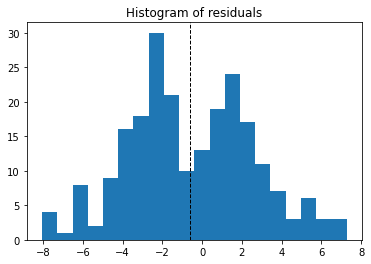

In [433]:
visualization_of_the_results(y_predict_test)
visualization_of_the_results(y_predict_polynomial_best)
visualization_of_the_results(y_predict_tree_best)
visualization_of_the_results(y_predict_forest_best)

Na podstawie przedstawionych wyników wyberamy najlepiej predykujący model: polynomialfeatures__degree: 1, dla 5% tick. 

In [434]:
model_filename = 'model_polynomial_degrre_1.pkl'
joblib.dump(polynomial_model, model_filename) 

['model_polynomial_degrre_1.pkl']